In [ ]:
!pip install yfinance
!pip install finta
!pip install mplfinance
import mplfinance as mpf
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 2.9 MB/s 


### The list with the indicator symbols is useful to help use produce more features for our model.

In [ ]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'DOGE-USD'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

### Now we pull our historical data from yfinance. We don’t have many features to work with — not particularly useful unless we find a way to normalize them at least or derive more features from them.

[*********************100%***********************]  1 of 1 completed


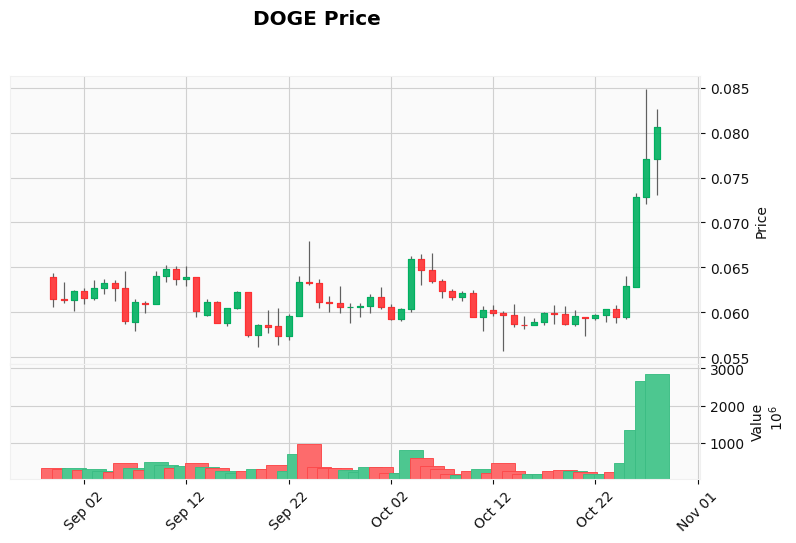

In [ ]:

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)

mpf.plot(data.iloc[-60:],type="candle",volume=True,tight_layout=False,style="yahoo",
        show_nontrading=True,scale_width_adjustment=dict(ohlc=1,lines=1,volume=2.4),
        title="DOGE Price",figratio=(20,12),ylabel='Price',
        ylabel_lower='Value')

In [ ]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)

# <font color='red'> 2. Data Processing & Feature Engineering

### We see that our data above is rough and contains lots of spikes for a time series. It isn’t very smooth and can be difficult for the model to extract trends from. To reduce the appearance of this we want to exponentially smooth our data before we compute the technical indicators.

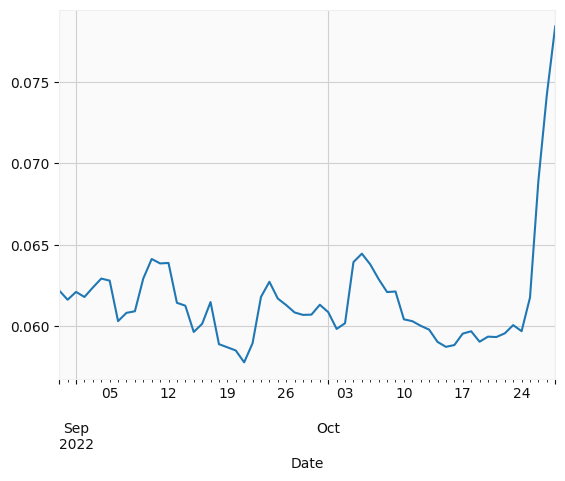

In [ ]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """

    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

### We can see that the data is much more smoothed. Having many peaks and troughs can make it hard to approximate, or be difficult to extract tends when computing the technical indicators. It can throw the model off.

### Now it’s time to compute our technical indicators. As stated above, I use the finta library in combination with python’s built in eval function to quickly compute all the indicators in the INDICATORS list. I also compute some ema’s at different average lengths in addition to a normalized volume value.

### I remove the columns like ‘Open’, ‘High’, ‘Low’, and ‘Adj Close’ because we can get a good enough approximation with our ema’s in addition to the indicators. Volume has been proven to have a correlation with price fluctuations, which is why I normalized it.

In [ ]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


### Right before we gather our predictions, I decided to keep a small bit of data to predict future values with.

In [ ]:
live_pred_data = data.iloc[-16:-11]

### Now comes one of the most important part of this project — computing the truth values. Without these, we wouldn’t even be able to train a machine learning model to make predictions.

In [ ]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """

    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)

    return data

data = _produce_prediction(data, window=5)
del (data['close'])
data = data.dropna()
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2022-10-19,40.655374,-0.000733,-0.000569,22.401627,9.903185e+10,0.002190,-0.003080,36.130635,-6.101009,5.518168e+10,-66.184902,-2.583059e-09,1.166905,0.895107,0.879977,0.959485,0.971404,0.986864,1.028856,1.0
2022-10-20,42.683821,-0.000722,-0.000599,31.379578,9.901212e+10,0.002068,-0.001063,24.502654,-4.404444,5.543059e+10,-61.288831,-3.081036e-09,1.205123,0.853941,0.886611,0.966088,0.978044,0.993369,0.978404,1.0
2022-10-21,42.569789,-0.000708,-0.000621,37.621504,9.913577e+10,0.002023,-0.000973,25.577311,-4.492705,5.519736e+10,-73.992456,-2.825145e-09,1.169535,0.852487,0.888254,0.967227,0.979129,0.994153,0.929670,1.0
2022-10-22,44.176468,-0.000670,-0.000631,45.653344,9.923473e+10,0.001983,-0.000462,31.613945,-1.422158,5.538262e+10,-54.003384,-2.180253e-09,1.124458,0.895885,0.893536,0.972198,0.983984,0.998283,0.772118,1.0
2022-10-23,47.686978,-0.000593,-0.000623,55.781026,9.938718e+10,0.001988,0.000276,37.256551,-0.402783,5.556610e+10,-38.318667,-1.849651e-09,1.089312,0.908401,0.902841,0.981289,0.992811,1.005595,0.795916,1.0


# <font color='red'> 3. Model Creation

### Right before we train our model we must split up the data into a train set and test set. However, due to the nature of time-series’, we need to handle this part carefully. If we randomize our train-test set, we could encounter a look-ahead bias which is not good for predicting the stock market. It’s caused when you train your model on data it would’ve already seen.
### To prevent this we are going to be training the model using a different technique called cross-validation. The image below illustrates how we are going to partition our data and test the accuracy of the model.

### First, we’re going to use multiple classifiers to create an ensemble model. The goal here is to combine the predictions of several models to try and improve on predictability. For each sub-model, we’re also going to use a feature from Sklearn, GridSearchCV, to optimize each model for the best possible results.
### First we create the random forest model.

In [ ]:
X=data.drop("pred",axis=1)
y=data["pred"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """

    # Create a new random forest classifier
    rf = RandomForestClassifier()

    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}

    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)

    # Fit model to training data
    rf_gs.fit(X_train, y_train)

    # Save best model
    rf_best = rf_gs.best_estimator_

    # Check best n_estimators value
    print(rf_gs.best_params_)

    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))

    return rf_best

rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82       344
         1.0       0.78      0.69      0.73       249

    accuracy                           0.79       593
   macro avg       0.78      0.77      0.78       593
weighted avg       0.79      0.79      0.78       593

[[295  49]
 [ 78 171]]


### Then the KNN model.

In [ ]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}

    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)

    # Fit model to training data
    knn_gs.fit(X_train, y_train)

    # Save best model
    knn_best = knn_gs.best_estimator_

    # Check best n_neigbors value
    print(knn_gs.best_params_)

    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))

    return knn_best


knn_model = _train_KNN(X_train, y_train, X_test, y_test)

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.66      0.83      0.74       344
         1.0       0.65      0.42      0.51       249

    accuracy                           0.66       593
   macro avg       0.66      0.63      0.62       593
weighted avg       0.66      0.66      0.64       593

[[287  57]
 [145 104]]


### And now finally we create the voting classifier

In [ ]:
def _train_GBT(X_train, y_train, X_test, y_test):

    gbt = GradientBoostingClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_gbt = {'n_estimators': np.arange(1, 25)}

    # Use gridsearch to test all values for n_neighbors
    gbt_gs = GridSearchCV(gbt, params_gbt, cv=5)

    # Fit model to training data
    gbt_gs.fit(X_train, y_train)

    # Save best model
    gbt_best = gbt_gs.best_estimator_

    # Check best n_neigbors value
    print(gbt_gs.best_params_)

    prediction = gbt_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))

    return gbt_best


gbt_model = _train_GBT(X_train, y_train, X_test, y_test)

{'n_estimators': 24}
              precision    recall  f1-score   support

         0.0       0.65      0.84      0.73       344
         1.0       0.62      0.37      0.46       249

    accuracy                           0.64       593
   macro avg       0.63      0.60      0.60       593
weighted avg       0.64      0.64      0.62       593

[[288  56]
 [157  92]]


In [ ]:
def _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test):

    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model), ('gbt', gbt_model)]

    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')

    #fit model to training data
    ensemble.fit(X_train, y_train)

    #test our model on the test data
    print(ensemble.score(X_test, y_test))

    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))

    return ensemble

ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

0.7234401349072512
              precision    recall  f1-score   support

         0.0       0.71      0.88      0.79       344
         1.0       0.76      0.50      0.60       249

    accuracy                           0.72       593
   macro avg       0.73      0.69      0.70       593
weighted avg       0.73      0.72      0.71       593

[[304  40]
 [124 125]]


# <font color='red'> 4. Prediction

### For the next step we’re going to predict how the DOGE coin will behave with our predictive model.

In [ ]:
live_pred_data.head()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2022-10-13,0.059800,41.666543,-0.000369,-0.000219,30.345644,9.922454e+10,0.002553,-0.000394,50.869818,-1.760506,5.537910e+10,-136.751390,-1.544176e-09,1.022382,0.933311,0.877915,0.959601,0.970378,0.978669,1.205294
2022-10-14,0.059048,38.877496,-0.000509,-0.000277,22.292175,9.917271e+10,0.002618,-0.004895,50.389465,-1.327369,5.508767e+10,-119.887047,-1.314428e-09,1.027098,0.948095,0.869142,0.949797,0.960852,0.971809,0.932159
2022-10-15,0.058744,37.776131,-0.000637,-0.000349,19.034982,9.911144e+10,0.002595,-0.005714,44.364741,-2.409885,5.486724e+10,-124.035027,-1.761690e-09,1.067529,0.941337,0.866966,0.947277,0.958721,0.972181,0.741535
2022-10-16,0.058854,38.458995,-0.000721,-0.000424,20.219647,9.906663e+10,0.002542,-0.004944,48.933484,-7.958479,5.504985e+10,-108.913373,-1.296248e-09,1.051383,0.969095,0.870842,0.951263,0.963061,0.978249,0.656505
2022-10-17,0.059557,42.754198,-0.000723,-0.000483,27.740615,9.915361e+10,0.002526,-0.003339,53.189775,-7.603601,5.522703e+10,-80.463757,-9.369286e-10,1.025635,0.980788,0.883292,0.964254,0.976210,0.991589,0.678012


### Here are the five main days we are going to generate a prediction for. Looks like the models predicts that the price will increase for each day.
### Lets validate our prediction with the actual results.

In [ ]:
del(live_pred_data['close'])
prediction = ensemble_model.predict(live_pred_data)
print(prediction)

[1. 1. 1. 1. 1.]


### As we can see from the actual results, we can confirm that the model was correct in all of its predictions. However there are many factors that go into determining the stock price, so to say that the model will produce similar results every time is naive. However, during relatively normal periods of time (without major panic that causes volatility in the market), the model should be able to produce good results.

# <font color='red'> 5. Summary

### To summarize what we’ve done in this project,
### We’ve collected data to be used in analysis and feature creation.
### We’ve used pandas to compute many model features and produce clean data to help us in machine learning. Created predictions or truth values using pandas.
### Ensured our predictions were accurate with real world data.
### Thanks for reading :)